# $ \frac{d^2y}{dx^2} + g(x)\frac{dy}{dx} = f_0(x) + f_1(x)y + f_2(x)y^2 + ...$  の解法

$ \frac{d^2y}{dx^2}+g(x)\frac{dy}{dx}= f_0 + f_1y + f_2y^2+...$とする。$z:=\frac{dy}{dx}$とすると

$$ \frac{dy}{dx}=z,~~~~~\frac{dz}{dx}+g(x)z= f_0 + f_1y + f_2y^2+... $$

$$ \frac{dy}{dx}=z,~~~~~\frac{dz}{dx}=-g(x)z+ f_0 + f_1y + f_2y^2+... =:G(x,y,z)$$

という連立(微分)方程式を得る。このとき

\begin{array}{ll}
k_{1}=h z_n & l_{1} =h G\left(x_{n}, y_{n}, z_{n}\right) \\
k_{2}=h \left(z_{n}+\frac{l_{1}}{2}\right) & l_{2} =h G\left(x_{n}+\frac{h}{2}, y_{n}+\frac{k_{1}}{2}, z_{n}+\frac{l_{1}}{2}\right) \\
k_{3}=h \left(z_{n}+\frac{l_{2}}{2}\right) & l_{3} =h G\left(x_{n}+\frac{h}{2}, y_{n}+\frac{k_{2}}{2}, z_{n}+\frac{l_{2}}{2}\right) \\
k_{4}=h \left(z_{n}+l_{3}\right) & l_{4} =hG\left(x_{n}+h, y_{n}+k_{3}, z_{n}+l_{3}\right) \\
k=\frac{1}{6}\left(k_{1}+2k_{2}+2k_{3}+k_{4}\right) & l =\frac{1}{6}\left(l_{1}+2l_{2}+2l_{3}+l_{4}\right) \\
y_{n+1}=y_{n}+k & z_{n+1} =z_{n}+l
\end{array}

となるので$k,l$は$z_n$の1次関数、$y_n$の[(最高次の次数)の4乗]次関数である。今、$y_0,\cdots ,y_{n-1},z_0,\cdots ,z_{n-1}$が未知変数である。書き下すと

\begin{array}{ll}
y_{1}=y_{0}+k(x_0,y_0,z_0) & z_{1} =z_{0}+l(x_0,y_0,z_0) \\
y_{2}=y_{1}+k(x_1,y_1,z_1) & z_{2} =z_{1}+l(x_1,y_1,z_1) \\
\vdots & \vdots \\
y_{n-1}=y_{n-2}+k(x_{n-2},y_{n-2},z_{n-2}) & z_{n-1} =z_{n-2}+l(x_{n-2},y_{n-2},z_{n-2})
\end{array}

つまり$y_0,\cdots ,y_{n-1},z_0,\cdots ,z_{n-1}$に関する非線形連立方程式を解けばよい。

## ①初期設定（解法共通）

In [2]:
from import_summary import *
from utility import *  # 計算基底に関する確率分布を表示
from HHL_function import *  # HHL algorithmに必要な関数
from copy import copy
import tqdm

In [3]:
# 多項式(の係数)list1と多項式(の係数)list2の掛け算、十分要素数が確保されているならenough=1
def times_poly(poly1, poly2, enough = 1):
    result = np.zeros((poly1.shape[0]+poly2.shape[0], poly1.shape[1]+poly2.shape[1]))
    for i in range(poly1.shape[0]):
        for j in range(poly1.shape[1]):
            for m in range(poly2.shape[0]):
                for n in range(poly2.shape[1]):
                    result[i+m][j+n] += poly1[i][j]*poly2[m][n]
            
            
    # list_1とlist_2の要素数は同じで、かつ配列の長さが十分のとき
    if enough == 1:
        result = np.array([i[:poly1.shape[1]] for i in result[:poly1.shape[0]]])
        
    return result

# 多項式(の係数)listの微分
def differential(poly, axis):
    result = np.zeros((poly.shape[0], poly.shape[1]))
    if axis == "y":
        for i in range(poly.shape[0]-1):
            for j in range(poly.shape[1]):
                result[i][j] = (i+1)*poly[i+1][j]
                
        return result
    
    elif axis == "z":
        for i in range(poly.shape[0]):
            for j in range(poly.shape[1]-1):
                result[i][j] = (j+1)*poly[i][j+1]
                
        return result
        
    else:
        print("axis error")
        sys.exit(1)
        

## ②解きたい微分方程式の設定、刻み幅、次元数、補助qubit数の設定

In [58]:
# 設定

np.set_printoptions(linewidth=200, precision=7, edgeitems=5)
number = 6
if number == 1:
    h = 0.01  # 刻み幅
    n = 100 # 考える区間[x_first, x_first + h*(n-1)]
    e = 5
    y_order = 1
    z_order = 1
    x_list = np.array([h * i for i in range(n)])
    y_exact = 2/5 * np.exp(5*x_list) + np.exp(-x_list) -x_list -2/5 # y(0)=1, dy/dx(0)=0
    diff_y_exact = 2 * np.exp(5*x_list) - np.exp(-x_list) -1
    y_first = copy(y_exact)
    diff_y_first = copy(diff_y_exact)
    
    def function(x, axis):
        # dy/dx = zの右辺
        func = np.zeros((1+y_order, 1+z_order))
        if axis == "y":
            func[0][1] = 1
            return func

        # dz/dx = 4z + 5y + (5x+6)
        elif axis == "z":
            func = np.zeros((1+y_order, 1+z_order))
            func[0][0] = 5 * x + 6
            func[1][0] = 5
            func[0][1] = 4
            return func
        
        else:
            print("unknown axis")
            sys.exit(1)
            
elif number == 2:
    # y = sin(x) + 2
    # d^2y/dx^2 = - y + 2, y(x_0) = 2, dy/dx(x_0) = 1
    h = 0.064  # 刻み幅
    n = 100 # 考える区間[x_first, x_first + h*(n-1)]
    e = 5
    y_order = 0
    z_order = 1
    x_list = np.array([h * i for i in range(n)])
    y_exact = np.sin(x_list) + 2 # y(0)=1, dy/dx(0)=0
    diff_y_exact = np.cos(x_list)
    y_first = copy(y_exact)
    diff_y_first = copy(diff_y_exact)
    
    def function(x, axis):
        # dy/dx = z
        func = np.zeros((1+y_order, 1+z_order))
        if axis == "y":
            func[0][1] = 1
            return func

        # dz/dx = -y + 2
        elif axis == "z":
            func = np.zeros((1+y_order, 1+z_order))
            func[0][0] = 2
            func[1][0] = -1
            return func
        
        else:
            print("unknown axis")
            sys.exit(1)
            
elif number == 3:
    # y = 2(exp(-x/4)sin(4x) + 1)
    # d^2y/dx^2=-1/2*dy/dx - 257y/16 + 257/8,y(0)=2,y'(0)=8
    h = 0.064  # 刻み幅
    n = 100 # 考える区間[x_first, x_first + h*(n-1)]
    e = 5
    y_order = 1
    z_order = 1
    x_list = np.array([h * i for i in range(n)])
    y_exact = 2*(np.exp(-x_list/4)*np.sin(4*x_list) + 1) # y(0)=1, dy/dx(0)=0
    diff_y_exact = 2*(-1/4*np.exp(-x_list/4)*np.sin(4*x_list) + 4*np.exp(-x_list/4)*np.cos(4*x_list))
    y_first = copy(y_exact)
    diff_y_first = copy(diff_y_exact)
    
    def function(x, axis):
        # dy/dx = z
        func = np.zeros((1+y_order, 1+z_order))
        if axis == "y":
            func[0][1] = 1
            return func

        # dz/dx=-1/2*z - 257y/16 + 257/8
        elif axis == "z":
            func = np.zeros((1+y_order, 1+z_order))
            func[0][0] = 257/8
            func[1][0] = -257/16
            func[0][1] = -1/2
            return func
        
        else:
            print("unknown axis")
            sys.exit(1)
            
            
elif number == 4:
    # d^2y/dt^2=b(dy/dt)-a(dy/dt)^2-s_cy,y(0)=0, y'(0)=0
    a_para = 250
    b_para = 50
    s_c_para = 1.2
    c_para = 1
    
    h = 0.01  # 刻み幅
    n = 100 # 考える区間[x_first, x_first + h*(n-1)]
    e = 5
    y_order = 1
    z_order = 2
    x_list = np.array([h * i for i in range(n)])
    y_exact = np.array([0.001]) # y(0)=3,y'(0)=7
    diff_y_exact = np.array([0])
    y_first = copy(y_exact)
    diff_y_first = copy(diff_y_exact)
    
    def function(x, axis):
        # dy/dx = z
        func = np.zeros((1+y_order, 1+z_order))
        if axis == "y":
            func[0][1] = 1
            return func

        # dz/dt=bz-az^2-s_cy
        elif axis == "z":
            func = np.zeros((1+y_order, 1+z_order))
            func[0][1] = b_para
            func[0][2] = -a_para
            func[1][0] = -s_c_para
            
            return func
        
        else:
            print("unknown axis")
            sys.exit(1)
            
            
elif number == 5:
    # d^2y/dx^2 = - g/l * sin(y), y(x_0) = 2, dy/dx(x_0) = 1
    omega = np.sqrt(9.80665/10)
    theta_max = np.pi/3
    k_para = np.sin(theta_max/2)
    
    h = 0.05  # 刻み幅
    n = 150 # 考える区間[x_first, x_first + h*(n-1)]
    e = 5
    y_order = 5
    z_order = 1
    x_list = np.array([h * i for i in range(n)])
    y_first = np.array([0])
    diff_y_first = np.array([2*omega*k_para])
    
    # beta = np.arctan(omega*y_first[0]/diff_y_first[0])
    # alpha = y_first[0]/np.sin(beta)
    # y_exact = alpha * np.sin(omega*x_list + beta)
    
    y_exact = np.array([])
    for i in range(x_list.shape[0]):
        y_exact = np.append(y_exact, 2 * np.arcsin(k_para * special.ellipj(omega*x_list[i], k_para**2)[0]))
            
    
    def function(x, axis):
        g = 9.80665
        l = 10
        # dy/dx = z
        func = np.zeros((1+y_order, 1+z_order))

        if axis == "y":
            func[0][1] = 1
            return func

        # dz/dx = -g/l sin(y)≒-g/l(y-y^3/3!+y^5/5!+...)
        elif axis == "z":
            func = np.zeros((1+y_order, 1+z_order))
            func[1][0] = -g/l * (1/math.factorial(1))
            func[3][0] = g/l * (1/math.factorial(3))
            func[5][0] = -g/l * (1/math.factorial(5))
            
            return func
        
        else:
            print("unknown axis")
            sys.exit(1)
            
elif number == 6:
    # d^2y/dt^2=-μ(y^2-1)(dy/dt)-y,y(0)=0, y'(0)=0 
    mu = 1.5
    
    h = 0.05  # 刻み幅
    n = 400 # 考える区間[x_first, x_first + h*(n-1)]
    e = 5
    y_order = 2
    z_order = 1
    x_list = np.array([h * i for i in range(n)])
    y_exact = np.array([0.5]) # y(0)=0.5,y'(0)=0
    diff_y_exact = np.array([0.0])
    y_first = copy(y_exact)
    diff_y_first = copy(diff_y_exact)
    
    def function(x, axis):
        # dy/dt = z
        func = np.zeros((1+y_order, 1+z_order))
        if axis == "y":
            func[0][1] = 1.0
            return func

        # dz/dt=-μ(y^2-1)z-y=-y+μz-μy^2z
        elif axis == "z":
            func = np.zeros((1+y_order, 1+z_order))
            func[1][0] = -1.0
            func[0][1] = mu
            func[2][1] = -mu
            
            return func
        
        else:
            print("unknown axis")
            sys.exit(1)
            
else:
    print("Invalid number.")
    sys.exit(1)

max_ydim = 2 * y_order ** 2 * z_order + y_order ** 2 + y_order * z_order ** 2 * (z_order+1)
max_zdim = 3 * y_order * z_order ** 2 + y_order **2  + z_order ** 4
scale_fac = 1.0
reg_nbit = 9 # 位相推定に使うレジスタの数
depth = 100
tol = 1e-5

## ③HHL algorithmによる解法

In [59]:
def jacobi_HHL(x, diff_y_k_coef_HHL, diff_z_k_coef_HHL, diff_y_l_coef_HHL, diff_z_l_coef_HHL):
    jacobi = np.eye(2 * n)
    for i in range(n - 1):
        jacobi[i + 1][i] = -1
        for y in range(1 + max_ydim):
            for z in range(1 + max_zdim):
                jacobi[i + 1][i] += -diff_y_k_coef_HHL[i][y][z] * (x[i] ** y) * (x[n + i] ** z)
                jacobi[i + 1][n + i] += -diff_z_k_coef_HHL[i][y][z] * (x[i] ** y) * (x[n + i] ** z)

    for i in range(n - 1):
        jacobi[n + i + 1][n + i] = -1
        for y in range(1 + max_ydim):
            for z in range(1 + max_zdim):
                jacobi[n + i + 1][n + i] += -diff_z_l_coef_HHL[i][y][z] * (x[i] ** y) * (x[n + i] ** z)
                jacobi[n + i + 1][i] += -diff_y_l_coef_HHL[i][y][z] * (x[i] ** y) * (x[n + i] ** z)

    return jacobi


def right_side_HHL(x, k_coef_HHL, l_coef_HHL):
    formula = np.array([0])
    for i in range(n - 1):
        k_poly = 0
        for y in range(1 + max_ydim):
            for z in range(1 + max_zdim):
                k_poly += k_coef_HHL[i][y][z] * (x[i] ** y) * (x[n + i] ** z)

        formula = np.append(formula, -x[i + 1] + x[i] + k_poly)  # (Jacobi行列)*解 = -(y_(n+1)-y_(n)+k)

    formula = np.append(formula, 0)
    for i in range(n - 1):
        l_poly = 0
        for y in range(1 + max_ydim):
            for z in range(1 + max_zdim):
                l_poly += l_coef_HHL[i][y][z] * (x[i] ** y) * (x[n + i] ** z)

        formula = np.append(formula, -x[n + i + 1] + x[n + i] + l_poly)  # (Jacobi行列)*解 = -(z_(n+1)-z_(n)+l)

    return formula


###################### Runge-kutta法(4次・HHL)専用 ######################
HHL_first = np.array([y_first[0] for i in range(len(x_list))]) # 初期条件
diff_HHL_first = np.array([diff_y_first[0] for i in range(len(x_list))]) # 初期条件

# HHL_first = copy(y_first)  # 初期条件
# diff_HHL_first = copy(diff_y_exact)  # 初期条件
# for i in range(1, len(HHL_first)):
#     HHL_first[i] += random.uniform(e, -e)
#     diff_HHL_first[i] += random.uniform(e, -e)

# Wx=cに直す
count = 0

k_coef_HHL = np.zeros((n, 1 + max_ydim, 1 + max_zdim))
l_coef_HHL = np.zeros((n, 1 + max_ydim, 1 + max_zdim))
diff_y_k_coef_HHL = np.zeros((n, 1 + max_ydim, 1 + max_zdim))
diff_z_k_coef_HHL = np.zeros((n, 1 + max_ydim, 1 + max_zdim))
diff_y_l_coef_HHL = np.zeros((n, 1 + max_ydim, 1 + max_zdim))
diff_z_l_coef_HHL = np.zeros((n, 1 + max_ydim, 1 + max_zdim))
f_value = np.zeros((1 + y_order, 1 + z_order, 3))
g_value = np.zeros((1 + y_order, 1 + z_order, 3))

start = time.time()

for _ in tqdm.tqdm(range(depth)):
    for i in range(n - 1):
        for y in range(1 + y_order):
            for z in range(1 + z_order):
                for m in range(3):
                    f_value[y][z][m] = function(x_list[i] + m * h / 2, "y")[y][z]  # f(x+m*h/2,y,z)のy^(.)z^(.)の係数
                    g_value[y][z][m] = function(x_list[i] + m * h / 2, "z")[y][z]  # g(x+m*h/2,y,z)のy^(.)z^(.)の係数
                    

        k_1 = np.zeros((1 + max_ydim, 1 + max_zdim))
        k_2 = np.zeros((1 + max_ydim, 1 + max_zdim))
        k_3 = np.zeros((1 + max_ydim, 1 + max_zdim))
        k_4 = np.zeros((1 + max_ydim, 1 + max_zdim))
        k = np.zeros((1 + max_ydim, 1 + max_zdim))

        l_1 = np.zeros((1 + max_ydim, 1 + max_zdim))
        l_2 = np.zeros((1 + max_ydim, 1 + max_zdim))
        l_3 = np.zeros((1 + max_ydim, 1 + max_zdim))
        l_4 = np.zeros((1 + max_ydim, 1 + max_zdim))
        l = np.zeros((1 + max_ydim, 1 + max_zdim))
        ################## k_1,l_1はここから ##################
        for y in range(1 + y_order):
            for z in range(1 + z_order):
                k_1[y][z] = h * f_value[y][z][0]

        for y in range(1 + y_order):
            for z in range(1 + z_order):
                l_1[y][z] = h * g_value[y][z][0]

        k += k_1 / 6.0
        l += l_1 / 6.0
        
        ################## k_1,l_1はここまで ##################
        ################## k_2,l_2はここから ##################
        k_1 = k_1 / 2
        k_1[1][0] += 1  # y+k_1/2
        l_1 = l_1 / 2
        l_1[0][1] += 1  # z+k_2/2

        k_temp = np.zeros((1 + y_order, 1 + max_ydim, 1 + max_zdim))
        l_temp = np.zeros((1 + z_order, 1 + max_ydim, 1 + max_zdim))

        k_temp[0][0][0] = 1  # (y+k_1/2)^0
        l_temp[0][0][0] = 1  # (z+k_1/2)^0
        for a in range(y_order):
            k_temp[a + 1] = times_poly(k_temp[a], k_1)  # k_temp[i]=(y+k_1/2)^i

        for b in range(z_order):
            l_temp[b + 1] = times_poly(l_temp[b], l_1)  # l_temp[i]=(z+l_1/2)^i

        for a in range(1 + y_order):
            for b in range(1 + z_order):
                k_2 += h * f_value[a][b][1] * times_poly(k_temp[a], l_temp[b])
                l_2 += h * g_value[a][b][1] * times_poly(k_temp[a], l_temp[b])

        k += k_2 / 3.0
        l += l_2 / 3.0

        ################## k_2,l_2はここまで ##################
        ################## k_3,l_3はここから ##################
        k_2 = k_2 / 2
        k_2[1][0] += 1  # y+k_2/2
        l_2 = l_2 / 2
        l_2[0][1] += 1  # z+k_2/2
        k_temp = np.zeros((1 + y_order, 1 + max_ydim, 1 + max_zdim))
        l_temp = np.zeros((1 + z_order, 1 + max_ydim, 1 + max_zdim))
        k_temp[0][0][0] = 1  # (y+k_2/2)^0
        l_temp[0][0][0] = 1  # (z+k_2/2)^0
        for a in range(y_order):
            k_temp[a + 1] = times_poly(k_temp[a], k_2)  # k_temp[i]=(y+k_2/2)^i

        for b in range(z_order):
            l_temp[b + 1] = times_poly(l_temp[b], l_2)  # l_temp[i]=(z+l_2/2)^i

        for a in range(1 + y_order):
            for b in range(1 + z_order):
                k_3 += h * f_value[a][b][1] * times_poly(k_temp[a], l_temp[b])
                l_3 += h * g_value[a][b][1] * times_poly(k_temp[a], l_temp[b])

        k += k_3 / 3.0
        l += l_3 / 3.0


        ################## k_3,l_3はここまで ##################
        ################## k_4,l_4はここから ##################
        k_3[1][0] += 1  # y+k_3
        l_3[0][1] += 1  # z+k_3
        k_temp = np.zeros((1 + y_order, 1 + max_ydim, 1 + max_zdim))
        l_temp = np.zeros((1 + z_order, 1 + max_ydim, 1 + max_zdim))
        k_temp[0][0][0] = 1  # (y+k_3/2)^0
        l_temp[0][0][0] = 1  # (z+k_3/2)^0
        for a in range(y_order):
            k_temp[a + 1] = times_poly(k_temp[a], k_3)  # k_temp[i]=(y+k_3)^i

        for b in range(z_order):
            l_temp[b + 1] = times_poly(l_temp[b], l_3)  # l_temp[i]=(z+l_3)^i

        for a in range(1 + y_order):
            for b in range(1 + z_order):
                k_4 += h * f_value[a][b][2] * times_poly(k_temp[a], l_temp[b])  # h*f_{ij}*(y+k_3)^i(z+l_3)^j
                l_4 += h * g_value[a][b][2] * times_poly(k_temp[a], l_temp[b])  # h*g_{ij}*(y+k_3)^i(z+l_3)^j

        k += k_4 / 6.0
        l += l_4 / 6.0
        ################## k_4,l_4はここまで ##################

        k_coef_HHL[i] = k  # kを多項式で表示したときの係数
        l_coef_HHL[i] = l  # lを多項式で表示したときの係数
        diff_y_k_coef_HHL[i] = differential(k, "y")  # dk/dyを多項式で表示したときの係数
        diff_z_k_coef_HHL[i] = differential(k, "z")  # dk/dyを多項式で表示したときの係数
        diff_y_l_coef_HHL[i] = differential(l, "y")  # dl/dyを多項式で表示したときの係数
        diff_z_l_coef_HHL[i] = differential(l, "z")  # dl/dyを多項式で表示したときの係数

    J_HHL = jacobi_HHL(np.concatenate([HHL_first, diff_HHL_first]), diff_y_k_coef_HHL, diff_z_k_coef_HHL,
                       diff_y_l_coef_HHL, diff_z_l_coef_HHL)  # Jacobi行列を計算
    b_HHL = right_side_HHL(np.concatenate([HHL_first, diff_HHL_first]), k_coef_HHL, l_coef_HHL)  # 連立方程式の右辺

    # Wは必ずHermiteではないので[[0,W],[W^T,0]]、[b,0]にする
    dim = 2 * (2 * n)  # もともと2n次元でHermiteにすると4n次元になる
    J_HHL = np.block([[np.zeros((2 * n, 2 * n)), J_HHL], [J_HHL.T, np.zeros((2 * n, 2 * n))]])  # 2n*2n次元の行列
    b_HHL = np.block([b_HHL, np.zeros(2 * n)])  # 2n次元のベクトル
    # Wの固有値を確認 -> [-pi, pi] に収まっている
    for value in np.linalg.eigh(J_HHL)[0]:
        if value < -np.pi or np.pi < value:
            print("caution:eigenvalues exist that are not included in [-π,π].")
            exit(1)

    y_HHL = HHL_algorithm(J_HHL, b_HHL, dim, reg_nbit, scale_fac)
    # y_HHL = np.linalg.solve(J_HHL, b_HHL)
    
#    if _ == 0:
#        D = np.linalg.solve(J_HHL, b_HHL)
#        print(D[2*n:3*n])
#        print(y_HHL[2 * n:3 * n])   
        
    print(np.average(np.abs(y_HHL[2 * n:3 * n])))
    if np.average(np.abs(y_HHL[2 * n:3 * n])) < tol:
        break
    else:
        HHL_first += y_HHL[2 * n:3 * n]
        diff_HHL_first += y_HHL[3 * n:4 * n]
        count += 1

t = time.time() - start
y_HHL_newton = HHL_first
print("HHL calculation completed.")
print("Elapsed time[s]:", t)
print("register qubits:", reg_nbit)
print("h:", h, " n:", n, " e:", e)
print("Number of updates:", count)

###################### Runge-kutta法(4次・HHL)専用 ######################

  0%|          | 0/100 [02:53<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
with open("HHL(number="+str(number)+",reg_qubits="+str(reg_nbit)+",e="+str(e)+",h="+str(h)+",n="+str(n)+",tol="+str(tol)+")", 'w') as f:
    writer = csv.writer(f)
    for i in range(n):
        writer.writerow([x_list[i], y_HHL_newton[i]])

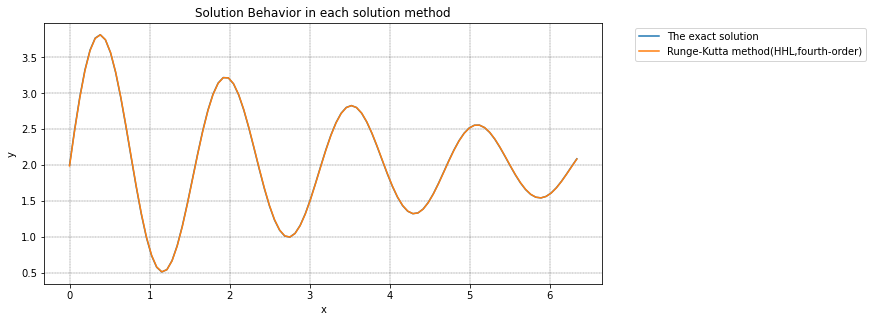

In [47]:
fig = plt.figure(figsize=(10,4.8))
plt.plot(x_list, y_exact, label="The exact solution")  # 厳密解をプロット
plt.plot(x_list, y_HHL_newton, label="Runge-Kutta method(HHL,fourth-order)")  # 4次のルンゲクッタ法(厳密)で求めた近似解をプロット

plt.title("Solution Behavior in each solution method")
plt.grid(color="black", linestyle='--', linewidth=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

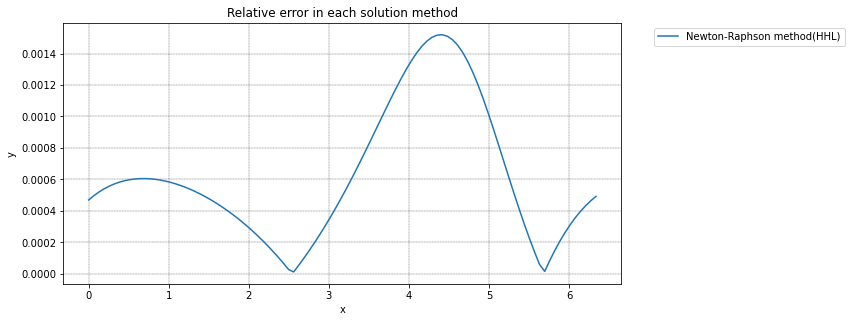

In [38]:
fig = plt.figure(figsize=(10,4.8))
plt.plot(x_list, abs((y_HHL_newton-y_exact)/y_exact), label="Newton-Raphson method(HHL)")  # オイラー法(厳密)で求めた近似解をプロット
plt.title("Relative error in each solution method")
plt.grid(color="black", linestyle='--', linewidth=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## ④Newton法による古典計算

In [11]:
def jacobi_newton(x, diff_y_k_coef_newton, diff_z_k_coef_newton, diff_y_l_coef_newton, diff_z_l_coef_newton):
    jacobi = np.eye(2*n)
    for i in range(n-1):
        jacobi[i+1][i] = -1
        for y in range(1 + max_ydim):
            for z in range(1 + max_zdim):
                jacobi[i+1][i] += -diff_y_k_coef_newton[i][y][z]*(x[i]**y)*(x[n+i]**z)
                jacobi[i+1][n+i] += -diff_z_k_coef_newton[i][y][z]*(x[i]**y)*(x[n+i]**z)
                
    for i in range(n-1):
        jacobi[n+i+1][n+i] = -1
        for y in range(1 + max_ydim):
            for z in range(1 + max_zdim):
                jacobi[n+i+1][n+i] += -diff_z_l_coef_newton[i][y][z]*(x[i]**y)*(x[n+i]**z)
                jacobi[n+i+1][i] += -diff_y_l_coef_newton[i][y][z]*(x[i]**y)*(x[n+i]**z)
    
    return jacobi

def right_side_newton(x, k_coef_newton, l_coef_newton):
    formula = np.array([0])
    for i in range(n-1):
        k_poly = 0
        for y in range(1 + max_ydim):
            for z in range(1 + max_zdim):
                k_poly += k_coef_newton[i][y][z]*(x[i]**y)*(x[n+i]**z)
            
        formula = np.append(formula, -x[i+1]+x[i]+k_poly) # (Jacobi行列)*解 = -(y_(n+1)-y_(n)+k)
        
    formula = np.append(formula, 0)
    for i in range(n-1):
        l_poly = 0
        for y in range(1 + max_ydim):
            for z in range(1 + max_zdim):
                l_poly += l_coef_newton[i][y][z]*(x[i]**y)*(x[n+i]**z)
                
        formula = np.append(formula, -x[n+i+1]+x[n+i]+l_poly) # (Jacobi行列)*解 = -(z_(n+1)-z_(n)+l)
    
    return formula

###################### Runge-kutta法(4次・Newton)専用 ######################

# newton_first = copy(y_first) # 初期条件
# diff_newton_first = copy(diff_y_exact)
# for i in range(1, len(newton_first)):
#     newton_first[i] += random.uniform(e, -e)

newton_first = np.array([y_first[0] for i in range(len(x_list))]) # 初期条件
diff_newton_first = np.array([diff_y_first[0] for i in range(len(x_list))]) # 初期条件

k_coef_newton = np.zeros((n, 1 + max_ydim, 1 + max_zdim))
l_coef_newton = np.zeros((n, 1 + max_ydim, 1 + max_zdim))
diff_y_k_coef_newton = np.zeros((n, 1 + max_ydim, 1 + max_zdim))
diff_z_k_coef_newton = np.zeros((n, 1 + max_ydim, 1 + max_zdim))
diff_y_l_coef_newton = np.zeros((n, 1 + max_ydim, 1 + max_zdim))
diff_z_l_coef_newton = np.zeros((n, 1 + max_ydim, 1 + max_zdim))
f_value = np.zeros((1+y_order, 1+z_order, 3))
g_value = np.zeros((1+y_order, 1+z_order, 3))

count = 0

start = time.time()
for _ in tqdm.tqdm(range(depth)):
    for i in range(n-1):
        for y in range(1+y_order):
            for z in range(1+z_order):
                for m in range(3):
                    f_value[y][z][m] = function(x_list[i] + m*h/2, "y")[y][z] # f(x+m*h/2,y,z)のy^(.)z^(.)の係数
                    g_value[y][z][m] = function(x_list[i] + m*h/2, "z")[y][z] # g(x+m*h/2,y,z)のy^(.)z^(.)の係数

        k_1 = np.zeros((1 + max_ydim, 1 + max_zdim))
        k_2 = np.zeros((1 + max_ydim, 1 + max_zdim))
        k_3 = np.zeros((1 + max_ydim, 1 + max_zdim))
        k_4 = np.zeros((1 + max_ydim, 1 + max_zdim))
        k = np.zeros((1 + max_ydim, 1 + max_zdim))

        l_1 = np.zeros((1 + max_ydim, 1 + max_zdim))
        l_2 = np.zeros((1 + max_ydim, 1 + max_zdim))
        l_3 = np.zeros((1 + max_ydim, 1 + max_zdim))
        l_4 = np.zeros((1 + max_ydim, 1 + max_zdim))
        l = np.zeros((1 + max_ydim, 1 + max_zdim))
        ################## k_1,l_1はここから ##################
        for y in range(1+y_order):
            for z in range(1+z_order):
                k_1[y][z] = h*f_value[y][z][0]

        for y in range(1+y_order):
            for z in range(1+z_order):
                l_1[y][z] = h*g_value[y][z][0]

        k += k_1/6.0
        l += l_1/6.0

        ################## k_1,l_1はここまで ##################
        ################## k_2,l_2はここから ##################
        k_1 = k_1/2
        k_1[1][0] += 1 # y+k_1/2
        l_1 = l_1/2
        l_1[0][1] += 1 # z+k_2/2
        k_temp = np.zeros((1+y_order, 1 + max_ydim, 1 + max_zdim))
        l_temp = np.zeros((1+z_order, 1 + max_ydim, 1 + max_zdim))
        k_temp[0][0][0] = 1 # (y+k_1/2)^0
        l_temp[0][0][0] = 1 # (z+k_1/2)^0
        for a in range(y_order):
            k_temp[a+1] = times_poly(k_temp[a], k_1) # k_temp[i]=(y+k_1/2)^i

        for b in range(z_order):
            l_temp[b+1] = times_poly(l_temp[b], l_1) # l_temp[i]=(z+l_1/2)^i

        for a in range(1+y_order):
            for b in range(1+z_order):
                k_2 += h*f_value[a][b][1]*times_poly(k_temp[a], l_temp[b])
                l_2 += h*g_value[a][b][1]*times_poly(k_temp[a], l_temp[b])

        k += k_2/3.0
        l += l_2/3.0

        ################## k_2,l_2はここまで ##################
        ################## k_3,l_3はここから ##################
        k_2 = k_2/2
        k_2[1][0] += 1 # y+k_2/2
        l_2 = l_2/2
        l_2[0][1] += 1 # z+k_2/2
        k_temp = np.zeros((1+y_order, 1 + max_ydim, 1 + max_zdim))
        l_temp = np.zeros((1+z_order, 1 + max_ydim, 1 + max_zdim))
        k_temp[0][0][0] = 1 # (y+k_2/2)^0
        l_temp[0][0][0] = 1 # (z+k_2/2)^0
        for a in range(y_order):
            k_temp[a+1] = times_poly(k_temp[a], k_2) # k_temp[i]=(y+k_2/2)^i

        for b in range(z_order):
            l_temp[b+1] = times_poly(l_temp[b], l_2) # l_temp[i]=(z+l_2/2)^i

        for a in range(1+y_order):
            for b in range(1+z_order):
                k_3 += h*f_value[a][b][1]*times_poly(k_temp[a], l_temp[b])
                l_3 += h*g_value[a][b][1]*times_poly(k_temp[a], l_temp[b])

        k += k_3/3.0
        l += l_3/3.0

        ################## k_3,l_3はここまで ##################
        ################## k_4,l_4はここから ##################
        k_3[1][0] += 1 # y+k_3
        l_3[0][1] += 1 # z+k_3
        k_temp = np.zeros((1+y_order, 1 + max_ydim, 1 + max_zdim))
        l_temp = np.zeros((1+z_order, 1 + max_ydim, 1 + max_zdim))
        k_temp[0][0][0] = 1 # (y+k_3/2)^0
        l_temp[0][0][0] = 1 # (z+k_3/2)^0
        for a in range(y_order):
            k_temp[a+1] = times_poly(k_temp[a], k_3) # k_temp[i]=(y+k_3)^i

        for b in range(z_order):
            l_temp[b+1] = times_poly(l_temp[b], l_3) # l_temp[i]=(z+l_3)^i

        for a in range(1+y_order):
            for b in range(1+z_order):
                k_4 += h*f_value[a][b][2]*times_poly(k_temp[a],l_temp[b]) # h*f_{ij}*(y+k_3)^i(z+l_3)^j
                l_4 += h*g_value[a][b][2]*times_poly(k_temp[a],l_temp[b]) # h*g_{ij}*(y+k_3)^i(z+l_3)^j

        k += k_4/6.0
        l += l_4/6.0
        ################## k_4,l_4はここまで ##################

        k_coef_newton[i] = k # kを多項式で表示したときの係数
        l_coef_newton[i] = l # lを多項式で表示したときの係数
        diff_y_k_coef_newton[i] = differential(k, "y") # dk/dyを多項式で表示したときの係数
        diff_z_k_coef_newton[i] = differential(k, "z") # dk/dyを多項式で表示したときの係数
        diff_y_l_coef_newton[i] = differential(l, "y") # dl/dyを多項式で表示したときの係数
        diff_z_l_coef_newton[i] = differential(l, "z") # dl/dyを多項式で表示したときの係数
        
    jacobi_matrix_newton = jacobi_newton(np.concatenate([newton_first, diff_newton_first]), diff_y_k_coef_newton, diff_z_k_coef_newton, diff_y_l_coef_newton, diff_z_l_coef_newton) # 係数行列の生成(Jacobi行列)
    right_newton = right_side_newton(np.concatenate([newton_first, diff_newton_first]), k_coef_newton, l_coef_newton) # 右辺の生成
#    if _ == 0:
#        J = np.block([[np.zeros((2 * n, 2 * n)), jacobi_matrix_newton], [jacobi_matrix_newton.T, np.zeros((2 * n, 2 * n))]])  # 2n*2n次元の行列
#        B = np.block([right_newton, np.zeros(2 * n)])  # 2n次元のベクトル
#        D = np.linalg.solve(J, B)
#        print(D[2*n:3*n])
    
    Delta = np.linalg.solve(jacobi_matrix_newton, right_newton)
        
    print(np.average(np.abs(Delta[:n])))
    
    if np.average(np.abs(Delta[:n])) < tol:
        break
    else:
        newton_first += Delta[:n]
        diff_newton_first += Delta[n:2*n]
        count += 1
    
t = time.time() - start
y_exact_newton = newton_first
print("Newton calculation completed.")
print("Elapsed time[s]:", t)
print("h:", h," n:", n, " e:", e)
print("Number of updates:", count)

###################### Runge-kutta法(4次・Newton)専用 ######################

  1%|          | 1/100 [00:10<17:42, 10.74s/it]

0.43794519745797933


  1%|          | 1/100 [00:21<36:05, 21.87s/it]

6.744725200244774e-16
Newton calculation completed.
Elapsed time[s]: 21.9307062625885
h: 0.01  n: 100  e: 5
Number of updates: 1


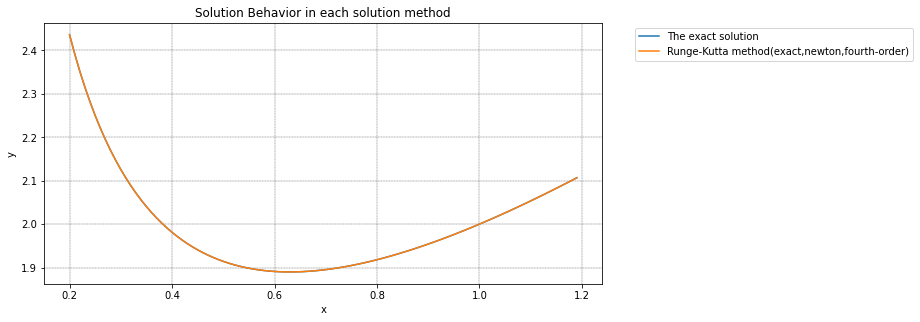

In [12]:
fig = plt.figure(figsize=(10,4.8))
plt.plot(x_list, y_exact, label="The exact solution")  # 厳密解をプロット
plt.plot(x_list, y_exact_newton, label="Runge-Kutta method(exact,newton,fourth-order)")  # 4次のルンゲクッタ法(厳密)で求めた近似解をプロット

plt.title("Solution Behavior in each solution method")
plt.grid(color="black", linestyle='--', linewidth=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## ⑤Runge-Kutta法

In [51]:
y_runge4 = np.zeros(len(x_list))  # y(x)
z_runge4 = np.zeros(len(x_list))  # z:=dy/dx
y_runge4[0] = y_first[0]
z_runge4[0] = diff_y_first[0]
# g = 9.80665
# length = 10
for i in range(len(x_list)-1):
    k_1, l_1 = 0, 0
    for a in range(1+y_order):
        for b in range(1+z_order):
            k_1 += h*function(x_list[i], "y")[a][b]*(y_runge4[i]**a)*(z_runge4[i]**b)
            l_1 += h*function(x_list[i], "z")[a][b]*(y_runge4[i]**a)*(z_runge4[i]**b)
            
    # l_1 = h*(-g/length)*np.sin(y_runge4[i])
    
    k_2, l_2 = 0, 0
    for a in range(1+y_order):
        for b in range(1+z_order):
            k_2 += h*function(x_list[i]+h/2, "y")[a][b]*((y_runge4[i]+k_1/2)**a)*((z_runge4[i]+l_1/2)**b)
            l_2 += h*function(x_list[i]+h/2, "z")[a][b]*((y_runge4[i]+k_1/2)**a)*((z_runge4[i]+l_1/2)**b)
    
    # l_2 = h*(-g/length)*np.sin(y_runge4[i]+k_1/2)
            
    k_3, l_3 = 0, 0
    for a in range(1+y_order):
        for b in range(1+z_order):
            k_3 += h*function(x_list[i]+h/2, "y")[a][b]*((y_runge4[i]+k_2/2)**a)*((z_runge4[i]+l_2/2)**b)
            l_3 += h*function(x_list[i]+h/2, "z")[a][b]*((y_runge4[i]+k_2/2)**a)*((z_runge4[i]+l_2/2)**b)
            
    # l_3 = h*(-g/length)*np.sin(y_runge4[i]+k_2/2)
    
    k_4, l_4 = 0, 0
    for a in range(1+y_order):
        for b in range(1+z_order):
            k_4 += h*function(x_list[i]+h, "y")[a][b]*((y_runge4[i]+k_3)**a)*((z_runge4[i]+l_3)**b)
            l_4 += h*function(x_list[i]+h, "z")[a][b]*((y_runge4[i]+k_3)**a)*((z_runge4[i]+l_3)**b)
        
    # l_4 = h*(-g/length)*np.sin(y_runge4[i]+k_3)
    
    k = (k_1 + 2*k_2 + 2*k_3 + k_4)/6
    l = (l_1 + 2*l_2 + 2*l_3 + l_4)/6
    
    y_runge4[i+1] = y_runge4[i] + k
    z_runge4[i+1] = z_runge4[i] + l
    

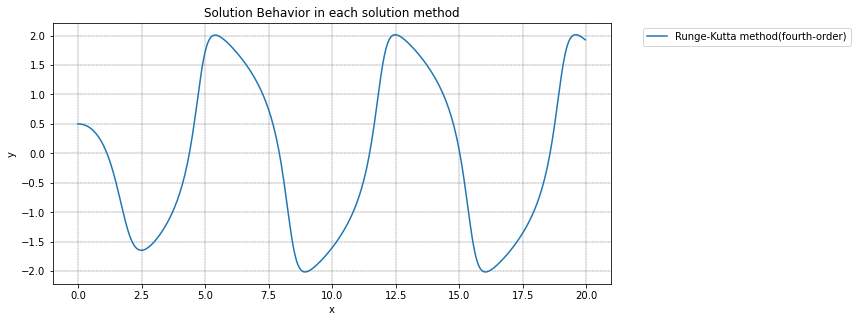

In [52]:
fig = plt.figure(figsize=(10,4.8))
# plt.plot(x_list, y_exact, label="The exact solution")  # 厳密解をプロット
plt.plot(x_list, y_runge4, label="Runge-Kutta method(fourth-order)")  # 4次のルンゲクッタ法(厳密)で求めた近似解をプロット

plt.title("Solution Behavior in each solution method")
plt.grid(color="black", linestyle='--', linewidth=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

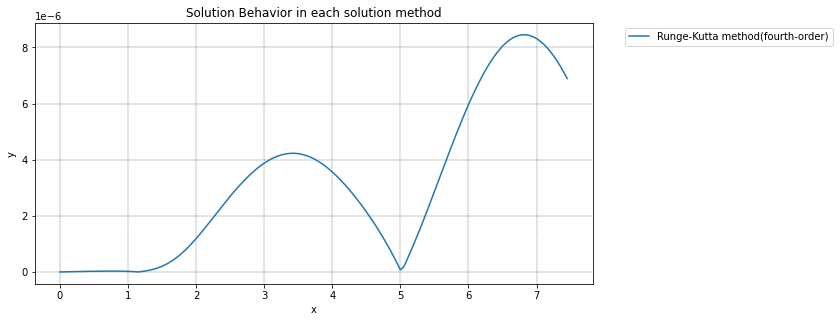

In [135]:
fig = plt.figure(figsize=(10,4.8))
plt.plot(x_list, np.abs(y_exact-y_runge4), label="Runge-Kutta method(fourth-order)")  # 4次のルンゲクッタ法(厳密)で求めた近似解をプロット

plt.title("Solution Behavior in each solution method")
plt.grid(color="black", linestyle='--', linewidth=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## ⑥それぞれのグラフ・相対誤差

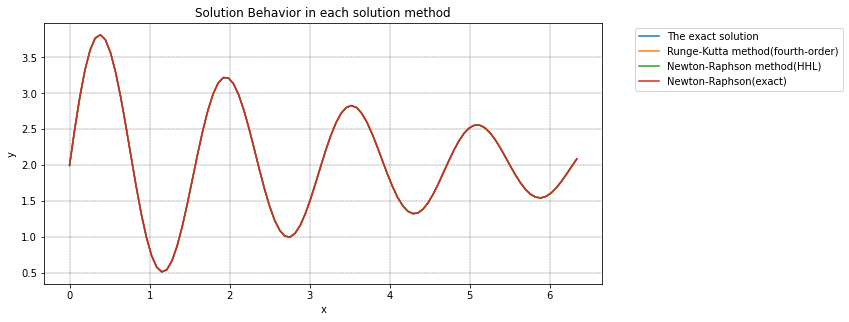

In [51]:
fig = plt.figure(figsize=(10,4.8))
plt.plot(x_list, y_exact, label="The exact solution")  # 厳密解をプロット
plt.plot(x_list, y_runge4, label="Runge-Kutta method(fourth-order)")  # Runge-Kutta法で求めた近似解をプロット
plt.plot(x_list, y_HHL_newton, label="Newton-Raphson method(HHL)")  # オイラー法(厳密)で求めた近似解をプロット
plt.plot(x_list, y_exact_newton, label="Newton-Raphson(exact)")  # オイラー法(HHL)で求めた近似解をプロット

plt.title("Solution Behavior in each solution method")
plt.grid(color="black", linestyle='--', linewidth=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
fig.savefig("2階ODE数値結果/plot(number="+str(number)+",reg_qubits="+str(reg_nbit)+",e="+str(e)+",h="+str(h)+",n="+str(n)+",tol="+str(tol)+").png", bbox_inches="tight")
plt.show()

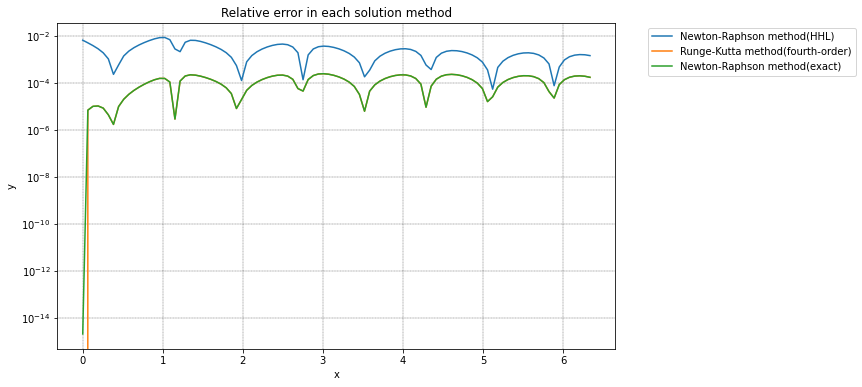

In [52]:
fig = plt.figure(figsize=(10,6))
plt.plot(x_list, abs((y_HHL_newton-y_exact)/y_exact), label="Newton-Raphson method(HHL)")  # オイラー法(厳密)で求めた近似解をプロット
plt.plot(x_list, abs((y_runge4-y_exact)/y_exact), label="Runge-Kutta method(fourth-order)")  # Runge-Kutta法で求めた近似解をプロット
plt.plot(x_list, abs((y_exact_newton-y_exact)/y_exact), label="Newton-Raphson method(exact)")  # オイラー法(HHL)で求めた近似解をプロット

plt.title("Relative error in each solution method")
plt.grid(color="black", linestyle='--', linewidth=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.yscale("log")
fig.savefig("2階ODE数値結果/error(number="+str(number)+",reg_qubits="+str(reg_nbit)+",e="+str(e)+",h="+str(h)+",n="+str(n)+",tol="+str(tol)+").png", bbox_inches="tight")
plt.show()